## Geneformer Embeddings

### Imports

In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
from env.imports import *

In [100]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [101]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 2.5%
RAM Usage: 5.7%
Available RAM: 949.6G
Total RAM: 1007.0G
52.4G


In [102]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 3.14 GB


### Setup

In [103]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

import anndata
from anndata import AnnData

from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor

In [104]:
# Load data
print("Loading data...")

X_UKBB_raw, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='raw_mirror_interpolate', return_valid_genes=True)
X_UKBB_srs, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='mirror_interpolate', return_valid_genes=True)
X_UKBB = X_UKBB_srs
Y_UKBB = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords_UKBB = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_UKBB = ~np.isnan(X_UKBB).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_UKBB = np.where(valid_indices_UKBB)[0]
valid2true_mapping_UKBB = dict(enumerate(valid_indices_values_UKBB))

# Subset all data using valid indices
X_UKBB_valid = X_UKBB[valid_indices_UKBB]
Y_UKBB_valid = Y_UKBB[valid_indices_UKBB][:, valid_indices_UKBB]
coords_UKBB_valid = coords_UKBB[valid_indices_UKBB]
labels_UKBB = [labels_UKBB[i] for i in range(len(labels_UKBB)) if valid_indices_UKBB[i]]
network_labels_UKBB = network_labels_UKBB[valid_indices_UKBB]

print(f"X_UKBB_valid shape: {X_UKBB_valid.shape}")

# Create dataset from X_UKBB_valid that contains each ROI as a sample
X = torch.tensor(X_UKBB_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_UKBB_valid.shape[0], shuffle=False)

print(X.shape)
print(X.dtype)

Loading data...
X_UKBB_valid shape: (455, 15633)
torch.Size([455, 15633])
torch.float32


In [105]:
# Create mapping from gene symbols to Ensembl IDs using example table from Geneformer, https://huggingface.co/api/resolve-cache/datasets/ctheodoris/Genecorpus-30M/71fae97a141652584e0cf09e8ace306e9b9e6d8c/example_input_files%2Fgene_info_table.csv?%2Fdatasets%2Fctheodoris%2FGenecorpus-30M%2Fresolve%2Fmain%2Fexample_input_files%2Fgene_info_table.csv=&etag=%2203d65efa77c6550c99889007f246294fc660000e%22
# For some reason the token dict for this model differs
gene_info_df = pd.read_csv('example_input_files_gene_info_table.txt')
symbol_to_ensembl = dict(zip(gene_info_df['gene_name'], gene_info_df['ensembl_id']))

# Convert gene symbols to Ensembl IDs where possible
ensembl_ids = []
unmapped_symbols = []

for symbol in valid_genes:
    if symbol in symbol_to_ensembl:
        ensembl_ids.append(symbol_to_ensembl[symbol])
    else:
        unmapped_symbols.append(symbol)
        ensembl_ids.append(None)

print(f"Successfully mapped {len(ensembl_ids) - len(unmapped_symbols)} genes to Ensembl IDs")
print(f"Could not map {len(unmapped_symbols)} genes")
print("\nFirst 10 mappings:")
for i in range(min(10, len(valid_genes))):
    print(f"{valid_genes[i]} -> {ensembl_ids[i]}")

print("ensembl ID format: ", ensembl_ids[:10])

Successfully mapped 15035 genes to Ensembl IDs
Could not map 598 genes

First 10 mappings:
A1BG -> ENSG00000121410
A1BG-AS1 -> ENSG00000268895
A2M -> ENSG00000175899
A2ML1 -> ENSG00000166535
A3GALT2 -> ENSG00000184389
A4GALT -> ENSG00000128274
AAAS -> ENSG00000094914
AACS -> ENSG00000081760
AADACL3 -> ENSG00000188984
AADAT -> ENSG00000109576
ensembl ID format:  ['ENSG00000121410', 'ENSG00000268895', 'ENSG00000175899', 'ENSG00000166535', 'ENSG00000184389', 'ENSG00000128274', 'ENSG00000094914', 'ENSG00000081760', 'ENSG00000188984', 'ENSG00000109576']


In [106]:
# Load the token dictionary and gene mapping dictionary
token_dict_path = "/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
gene_mapping_file = "/scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl"

with open(token_dict_path, 'rb') as f:
    token_dict = pickle.load(f)

with open(gene_mapping_file, 'rb') as f:
    gene_mapping = pickle.load(f)

# Map valid_genes to ensembl IDs for anndata var names
if 'valid_genes' in locals():
    ensembl_mapping = {}
    unmapped_genes = []
    
    for gene in valid_genes:
        if gene in gene_mapping:
            ensembl_mapping[gene] = gene_mapping[gene]
        else:
            unmapped_genes.append(gene)
            
    print(f"Successfully mapped {len(ensembl_mapping)} out of {len(valid_genes)} genes")
    print(f"Number of unmapped genes: {len(unmapped_genes)}")
    
    # Show sample of mappings
    print("\nSample HGNC to Ensembl mappings:")
    for gene, ensembl in list(ensembl_mapping.items())[:5]:
        print(f"{gene} -> {ensembl}")
        
    if unmapped_genes:
        print("\nSample unmapped genes:")
        print(unmapped_genes[:5])
        
    # Verify these ensembl IDs exist in token dictionary
    ensembl_in_token = [eid for eid in ensembl_mapping.values() if eid in token_dict]
    print(f"\nEnsembl IDs found in token dictionary: {len(ensembl_in_token)} out of {len(ensembl_mapping)}")
    
    if ensembl_in_token:
        print("\nSample token mappings:")
        for eid in list(ensembl_in_token)[:5]:
            print(f"{eid} -> {token_dict[eid]}")


Successfully mapped 14837 out of 15633 genes
Number of unmapped genes: 796

Sample HGNC to Ensembl mappings:
A1BG -> ENSG00000121410
A1BG-AS1 -> ENSG00000268895
A2M -> ENSG00000175899
A2ML1 -> ENSG00000166535
A3GALT2 -> ENSG00000184389

Sample unmapped genes:
['AAED1', 'AARS', 'ACPP', 'ADPRHL2', 'ADSS']

Ensembl IDs found in token dictionary: 14111 out of 14837

Sample token mappings:
ENSG00000121410 -> 5114
ENSG00000175899 -> 13651
ENSG00000166535 -> 11687
ENSG00000184389 -> 15062
ENSG00000128274 -> 5926


Setup AnnData file for tokenization

In [141]:
X_np = X.cpu().numpy()

# Map genes to Ensembl IDs using gene_mapping
ensembl_ids = []
valid_indices = []
for i, gene in enumerate(valid_genes):
    if gene in gene_mapping:
        ensembl_id = gene_mapping[gene]
        if ensembl_id in token_dict:  # Verify ID exists in token dictionary
            ensembl_ids.append(ensembl_id)
            valid_indices.append(i)

# Filter data to only include genes with valid Ensembl IDs
X_np_filtered = X_np[:, valid_indices]

# Create AnnData object with filtered counts
adata = AnnData(X_np_filtered)

# Assign Ensembl IDs as variable names and annotation
adata.var_names = ensembl_ids
adata.var["ensembl_id"] = ensembl_ids

# Assign cell/sample IDs
adata.obs_names = [f"sample_{i}" for i in range(X_np_filtered.shape[0])]

# Add required metadata for tokenization
adata.obs["n_counts"] = X_np_filtered.sum(axis=1)
adata.obs["organ_major"] = "brain"

# Save AnnData object with filtered genes
adata.write_h5ad("./data/geneformer/ahba_pseudocounts.h5ad")

In [142]:
# Load your AnnData object
adata = anndata.read_h5ad("./data/geneformer/ahba_pseudocounts.h5ad")

# --- Basic structure ---
print("🧬 Shape of X (cells x genes):", adata.shape)
print("📋 Type of X:", type(adata.X))

# --- obs: Metadata for observations (cells) ---
print("\n🔎 `adata.obs` (cell-level metadata):")
display(adata.obs.head())
print("📊 Columns in `obs`:", list(adata.obs.columns))

# --- var: Metadata for variables (genes) ---
print("\n🧬 `adata.var` (gene-level metadata):")
display(adata.var.head())
print("🧬 Columns in `var`:", list(adata.var.columns))

# --- layers (optional) ---
print("\n🧱 Layers (if any):", list(adata.layers.keys()) if adata.layers else "None")

# --- uns: Unstructured data (e.g., UMAP settings, config) ---
print("\n📦 `adata.uns` keys:", list(adata.uns.keys()))

# --- obsm / varm: Multi-dimensional annotations (e.g., PCA/UMAP coordinates) ---
print("📐 `adata.obsm` keys (e.g., UMAP):", list(adata.obsm.keys()))
print("📐 `adata.varm` keys:", list(adata.varm.keys()))

# --- Check for specific common elements ---
if "ensembl_id" in adata.var.columns:
    print("\n✅ 'ensembl_id' found in `adata.var`.")
    valid_genes = list(adata.var["ensembl_id"])
    print(f"Number of valid genes: {len(valid_genes)}")
else:
    print("\n⚠️ 'ensembl_id' missing from `adata.var`.")
    valid_genes = []

if "n_counts" in adata.obs.columns:
    print("✅ 'n_counts' found in `adata.obs`.")
else:
    print("⚠️ 'n_counts' missing from `adata.obs`.")

# Print initial number of genes using valid_genes list
print("Initial number of genes:", len(valid_genes))
print("Initial number of unique genes:", len(set(valid_genes)))

🧬 Shape of X (cells x genes): (455, 14111)
📋 Type of X: <class 'numpy.ndarray'>

🔎 `adata.obs` (cell-level metadata):


,n_counts,organ_major
sample_0,7178.782227,brain
sample_1,7031.654785,brain
sample_2,6943.846191,brain
sample_3,7142.410645,brain
sample_4,6944.451660,brain


📊 Columns in `obs`: ['n_counts', 'organ_major']

🧬 `adata.var` (gene-level metadata):


,ensembl_id
ENSG00000121410,ENSG00000121410
ENSG00000175899,ENSG00000175899
ENSG00000166535,ENSG00000166535
ENSG00000184389,ENSG00000184389
ENSG00000128274,ENSG00000128274


🧬 Columns in `var`: ['ensembl_id']

🧱 Layers (if any): None

📦 `adata.uns` keys: []
📐 `adata.obsm` keys (e.g., UMAP): []
📐 `adata.varm` keys: []

✅ 'ensembl_id' found in `adata.var`.
Number of valid genes: 14111
✅ 'n_counts' found in `adata.obs`.
Initial number of genes: 14111
Initial number of unique genes: 14111


In [143]:
tokenizer = TranscriptomeTokenizer(
    custom_attr_name_dict={"organ_major": "organ_major"},  # ✅ must match name in `.obs`
    nproc=16,
    model_version="V2",
    gene_median_file="/scratch/asr655/main_env/Geneformer/geneformer/gene_median_dictionary_gc104M.pkl",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl",
    gene_mapping_file="/scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl"
)

In [144]:
tokenizer.tokenize_data(
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer",
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer",
    "ahba_tokenized",
    file_format="h5ad"
)

Tokenizing /scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad
/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


In [137]:
# gene_token_dict maps Ensembl ID → token ID
gene_token_dict = tokenizer.gene_token_dict
mapped_genes_set = set(gene_token_dict.keys())

# From your AnnData
dataset_genes = set(adata.var["ensembl_id"])

mapped_genes = dataset_genes.intersection(mapped_genes_set)
unmapped_genes = dataset_genes - mapped_genes

print(f"🔢 Total genes in dataset: {len(dataset_genes)}")
print(f"✅ Mapped to tokens: {len(mapped_genes)}")
print(f"❌ Not mapped: {len(unmapped_genes)}")
print(f"🧬 Mapping rate: {len(mapped_genes)/len(dataset_genes):.2%}")
print("Unmapped genes (example):", list(unmapped_genes)[:10])

🔢 Total genes in dataset: 15633
✅ Mapped to tokens: 0
❌ Not mapped: 15633
🧬 Mapping rate: 0.00%
Unmapped genes (example): ['LINC00950', 'STAG3L5P', 'IRAK1BP1', 'MYBL1', 'FBLL1', 'AGAP2-AS1', 'DAAM1', 'KIAA1586', 'POLA1', 'MRPS22']


In [138]:
from datasets import load_from_disk

ds = load_from_disk("/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_tokenized.dataset")

print("✅ Dataset loaded")
print("🔢 Number of samples:", len(ds))

if len(ds) > 0:
    print("📄 First sample keys:", ds[0].keys())
    print("🧬 First sample input_ids:", ds[0]['input_ids'][:10])
    print("🧠 First sample labels:", ds[0].get('labels', None))
else:
    print("❌ Dataset is empty!")

✅ Dataset loaded
🔢 Number of samples: 0
❌ Dataset is empty!


In [139]:
embex = EmbExtractor(
    model_type="Pretrained",
    num_classes=0,
    emb_mode="cell",
    cell_emb_style="mean_pool",
    emb_layer=-1,
    emb_label=["organ_major"],
    labels_to_plot=["organ_major"],
    max_ncells=None,
    forward_batch_size=128,
    nproc=16,
    model_version="V2",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
)

In [140]:

model_path = "/scratch/asr655/main_env/Geneformer/Geneformer-V2-104M"
tokenized_data_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_tokenized.dataset"
output_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/embeddings"
output_prefix = 'ahba_embeddings'
embs = embex.extract_embs(
    model_directory=model_path,
    input_data_file=tokenized_data_path,
    output_directory=output_dir,
    output_prefix=output_prefix, 
    output_torch_embs=False
)

  self.comm = Comm(**args)



0it [00:00, ?it/s]

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [89]:
embs

NameError: name 'embs' is not defined

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



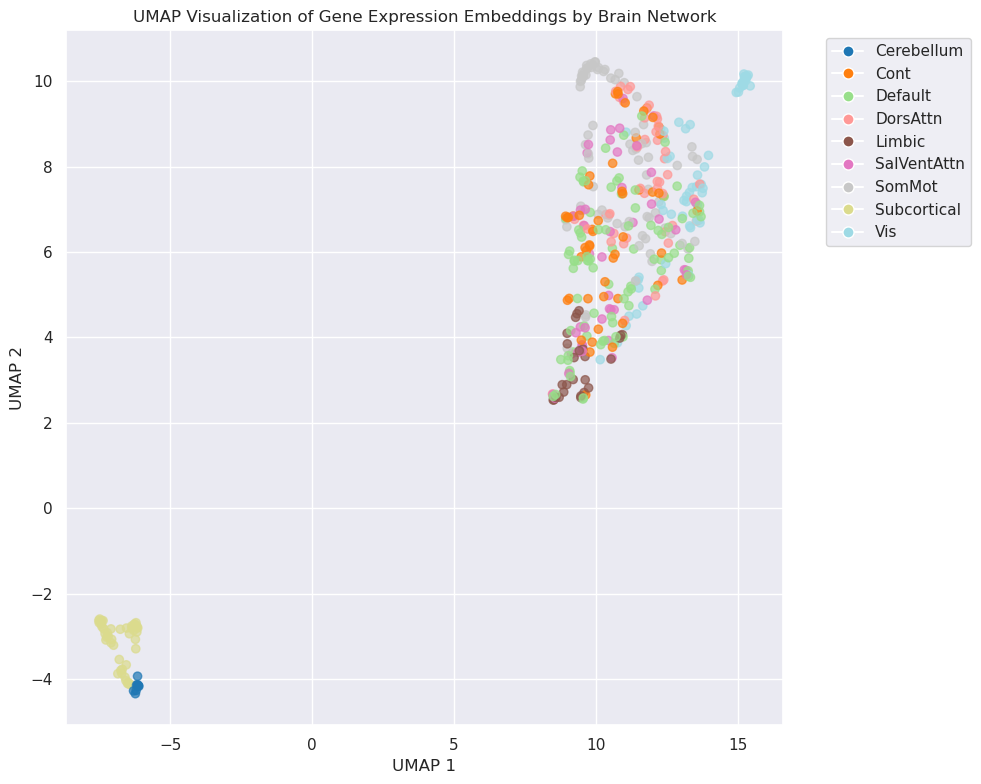

In [50]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Create UMAP reducer
reducer = umap.UMAP(random_state=42)

# Fit and transform the embeddings (excluding the organ_major column)
embedding_cols = embs.select_dtypes(include=['float64', 'float32']).columns
umap_embeddings = reducer.fit_transform(embs[embedding_cols])

# Define colors for each network
unique_networks = np.unique(network_labels_UKBB)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_networks)))
color_dict = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = [color_dict[label] for label in network_labels_UKBB]

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                     c=point_colors, alpha=0.7)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=color_dict[label], label=label, markersize=8)
                  for label in unique_networks]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP Visualization of Gene Expression Embeddings by Brain Network')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()

### Verify Tokenizer File Paths and Contents


In [20]:
import os
import pickle

print("=== TOKENIZER FILE PATH VERIFICATION ===\n")

# Define the file paths used in tokenizer
tokenizer_files = {
    "gene_median_file": "/scratch/asr655/main_env/Geneformer/geneformer/gene_median_dictionary_gc104M.pkl",
    "token_dictionary_file": "/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl", 
    "gene_mapping_file": "/scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl"
}

# Check if files exist
print("🔍 File existence check:")
for file_type, file_path in tokenizer_files.items():
    exists = os.path.exists(file_path)
    size = os.path.getsize(file_path) if exists else 0
    print(f"  {file_type}: {'✅' if exists else '❌'}")
    print(f"    Path: {file_path}")
    if exists:
        print(f"    Size: {size:,} bytes ({size/1024/1024:.1f} MB)")
    print()


=== TOKENIZER FILE PATH VERIFICATION ===

🔍 File existence check:
  gene_median_file: ✅
    Path: /scratch/asr655/main_env/Geneformer/geneformer/gene_median_dictionary_gc104M.pkl
    Size: 1,512,661 bytes (1.4 MB)

  token_dictionary_file: ✅
    Path: /scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl
    Size: 425,590 bytes (0.4 MB)

  gene_mapping_file: ✅
    Path: /scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl
    Size: 1,660,882 bytes (1.6 MB)



In [21]:
# Load and validate each pickle file content
print("=== PICKLE FILE CONTENT VALIDATION ===\n")

loaded_files = {}

for file_type, file_path in tokenizer_files.items():
    if os.path.exists(file_path):
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            loaded_files[file_type] = data
            
            print(f"📁 {file_type}:")
            print(f"   Type: {type(data)}")
            
            if isinstance(data, dict):
                print(f"   Length: {len(data)} entries")
                
                # Show sample entries
                sample_items = list(data.items())[:3]
                print(f"   Sample entries:")
                for key, value in sample_items:
                    print(f"     {key} -> {value} ({type(value).__name__})")
                    
                # Check key and value types
                key_types = set(type(k).__name__ for k in list(data.keys())[:100])
                value_types = set(type(v).__name__ for v in list(data.values())[:100])
                print(f"   Key types: {key_types}")
                print(f"   Value types: {value_types}")
                
            elif isinstance(data, (list, tuple)):
                print(f"   Length: {len(data)} elements")
                print(f"   Sample elements: {data[:3]}")
            else:
                print(f"   Content preview: {str(data)[:100]}...")
                
        except Exception as e:
            print(f"❌ Error loading {file_type}: {e}")
        
        print()
    else:
        print(f"❌ {file_type}: File not found at {file_path}\n")


=== PICKLE FILE CONTENT VALIDATION ===

📁 gene_median_file:
   Type: <class 'dict'>
   Length: 42005 entries
   Sample entries:
     ENSG00000121410 -> 1.7629378614450941 (float64)
     ENSG00000268895 -> 0.7785260715031078 (float64)
     ENSG00000148584 -> 2.1814515365129137 (float64)
   Key types: {'str'}
   Value types: {'float64'}

📁 token_dictionary_file:
   Type: <class 'dict'>
   Length: 20275 entries
   Sample entries:
     <pad> -> 0 (int)
     <mask> -> 1 (int)
     <cls> -> 2 (int)
   Key types: {'str'}
   Value types: {'int'}

📁 gene_mapping_file:
   Type: <class 'dict'>
   Length: 63675 entries
   Sample entries:
     5S_rRNA -> ENSG00000277411 (str)
     5_8S_rRNA -> ENSG00000277739 (str)
     7SK -> ENSG00000271394 (str)
   Key types: {'str'}
   Value types: {'str'}



In [22]:
# Cross-validate the files work together properly
print("=== CROSS-VALIDATION OF FILES ===\n")

if len(loaded_files) == 3:
    token_dict = loaded_files.get("token_dictionary_file", {})
    gene_mapping = loaded_files.get("gene_mapping_file", {})
    gene_median = loaded_files.get("gene_median_file", {})
    
    print("🔗 Checking consistency between files:")
    
    # Check if gene_mapping values exist in token_dict
    if isinstance(gene_mapping, dict) and isinstance(token_dict, dict):
        mapping_values = set(gene_mapping.values())
        token_keys = set(token_dict.keys())
        overlap = mapping_values & token_keys
        
        print(f"   Gene mapping values in token dict: {len(overlap)} out of {len(mapping_values)}")
        print(f"   Coverage: {len(overlap)/len(mapping_values)*100:.1f}%")
        
        if len(mapping_values) - len(overlap) > 0:
            missing = mapping_values - token_keys
            print(f"   Missing from token dict: {len(missing)} entries")
            print(f"   Examples: {list(missing)[:5]}")
    
    # Check gene_median vs token_dict
    if isinstance(gene_median, dict) and isinstance(token_dict, dict):
        median_keys = set(gene_median.keys())
        token_keys = set(token_dict.keys())
        overlap = median_keys & token_keys
        
        print(f"\n   Gene median keys in token dict: {len(overlap)} out of {len(median_keys)}")
        print(f"   Coverage: {len(overlap)/len(median_keys)*100:.1f}%")
        
    # Check gene_mapping vs gene_median
    if isinstance(gene_mapping, dict) and isinstance(gene_median, dict):
        mapping_values = set(gene_mapping.values())
        median_keys = set(gene_median.keys())
        overlap = mapping_values & median_keys
        
        print(f"\n   Gene mapping values in median dict: {len(overlap)} out of {len(mapping_values)}")
        print(f"   Coverage: {len(overlap)/len(mapping_values)*100:.1f}%")
        
else:
    print("❌ Cannot perform cross-validation - not all files loaded successfully")
    print(f"   Loaded files: {list(loaded_files.keys())}")


=== CROSS-VALIDATION OF FILES ===

🔗 Checking consistency between files:
   Gene mapping values in token dict: 20271 out of 63675
   Coverage: 31.8%
   Missing from token dict: 43404 entries
   Examples: ['ENSG00000242044', 'ENSG00000276255', 'ENSG00000273888', 'ENSG00000266537', 'ENSG00000289100']

   Gene median keys in token dict: 20271 out of 42005
   Coverage: 48.3%

   Gene mapping values in median dict: 42005 out of 63675
   Coverage: 66.0%


In [23]:
# Check compatibility with your data
print("=== COMPATIBILITY WITH YOUR DATA ===\n")

if 'valid_genes' in locals() and len(loaded_files) >= 2:
    token_dict = loaded_files.get("token_dictionary_file", {})
    gene_mapping = loaded_files.get("gene_mapping_file", {})
    
    print(f"📊 Your data has {len(valid_genes)} genes")
    
    # Check how many of your genes are in gene_mapping
    if isinstance(gene_mapping, dict):
        genes_in_mapping = [g for g in valid_genes if g in gene_mapping]
        print(f"   Genes found in mapping file: {len(genes_in_mapping)} out of {len(valid_genes)}")
        print(f"   Coverage: {len(genes_in_mapping)/len(valid_genes)*100:.1f}%")
        
        if len(genes_in_mapping) > 0:
            # Check how many of the mapped Ensembl IDs are in token_dict
            mapped_ensembl = [gene_mapping[g] for g in genes_in_mapping]
            ensembl_in_tokens = [eid for eid in mapped_ensembl if eid in token_dict]
            
            print(f"   Mapped Ensembl IDs in token dict: {len(ensembl_in_tokens)} out of {len(mapped_ensembl)}")
            print(f"   Final tokenizable genes: {len(ensembl_in_tokens)} out of {len(valid_genes)} ({len(ensembl_in_tokens)/len(valid_genes)*100:.1f}%)")
            
            # Show some examples
            print(f"\n   Sample tokenizable genes:")
            for i, gene in enumerate(genes_in_mapping[:5]):
                ensembl = gene_mapping[gene]
                token_id = token_dict.get(ensembl, "NOT_FOUND")
                print(f"     {gene} -> {ensembl} -> {token_id}")
        
        # Show some unmapped genes
        unmapped_genes = [g for g in valid_genes if g not in gene_mapping]
        if unmapped_genes:
            print(f"\n   Sample unmapped genes: {unmapped_genes[:10]}")
            
    else:
        print("   ❌ Gene mapping file is not a dictionary")
        
else:
    print("❌ Cannot check compatibility - missing valid_genes or loaded files")


=== COMPATIBILITY WITH YOUR DATA ===

📊 Your data has 15633 genes
   Genes found in mapping file: 14837 out of 15633
   Coverage: 94.9%
   Mapped Ensembl IDs in token dict: 14111 out of 14837
   Final tokenizable genes: 14111 out of 15633 (90.3%)

   Sample tokenizable genes:
     A1BG -> ENSG00000121410 -> 5114
     A1BG-AS1 -> ENSG00000268895 -> NOT_FOUND
     A2M -> ENSG00000175899 -> 13651
     A2ML1 -> ENSG00000166535 -> 11687
     A3GALT2 -> ENSG00000184389 -> 15062

   Sample unmapped genes: ['AAED1', 'AARS', 'ACPP', 'ADPRHL2', 'ADSS', 'ADSSL1', 'AES', 'AGPAT4-IT1', 'ALG1L', 'ALPPL2']


In [24]:
# Verify model version compatibility
print("=== MODEL VERSION COMPATIBILITY CHECK ===\n")

# Check if the model version matches the dictionary files
model_path = "/scratch/asr655/main_env/Geneformer/Geneformer-V2-104M"
print(f"🤖 Model path: {model_path}")
print(f"   Model exists: {'✅' if os.path.exists(model_path) else '❌'}")

if os.path.exists(model_path):
    # List contents of model directory
    model_contents = os.listdir(model_path)
    print(f"   Model directory contents: {model_contents}")
    
    # Check for config files that might indicate version
    config_files = [f for f in model_contents if 'config' in f.lower()]
    if config_files:
        print(f"   Config files found: {config_files}")

# Check if file names indicate same model version (gc104M)
print(f"\n🔍 File version consistency:")
file_versions = []
for file_type, file_path in tokenizer_files.items():
    filename = os.path.basename(file_path)
    if "gc104M" in filename:
        file_versions.append("gc104M")
    elif "gc30M" in filename:
        file_versions.append("gc30M")
    else:
        file_versions.append("unknown")
    print(f"   {file_type}: {filename} -> version: {file_versions[-1]}")

if len(set(file_versions)) == 1:
    print(f"✅ All files use consistent version: {file_versions[0]}")
else:
    print(f"⚠️ Mixed versions detected: {set(file_versions)}")

# Check tokenizer configuration
print(f"\n⚙️ Tokenizer configuration:")
print(f"   model_version: V2")
print(f"   Expected files version: gc104M")
print(f"   Model path version: {os.path.basename(model_path)}")

version_match = "104M" in os.path.basename(model_path) and all("gc104M" in v for v in file_versions if v != "unknown")
print(f"   Version consistency: {'✅' if version_match else '⚠️'}")


=== MODEL VERSION COMPATIBILITY CHECK ===

🤖 Model path: /scratch/asr655/main_env/Geneformer/Geneformer-V2-104M
   Model exists: ✅
   Model directory contents: ['model.safetensors', 'config.json', 'training_args.bin', 'generation_config.json']
   Config files found: ['config.json', 'generation_config.json']

🔍 File version consistency:
   gene_median_file: gene_median_dictionary_gc104M.pkl -> version: gc104M
   token_dictionary_file: token_dictionary_gc104M.pkl -> version: gc104M
   gene_mapping_file: gene_name_id_dict_gc104M.pkl -> version: gc104M
✅ All files use consistent version: gc104M

⚙️ Tokenizer configuration:
   model_version: V2
   Expected files version: gc104M
   Model path version: Geneformer-V2-104M
   Version consistency: ✅


In [ ]:
# Final summary and recommendations
print("=== SUMMARY AND RECOMMENDATIONS ===\n")

# Count successful validations
validations = {
    "Files exist": all(os.path.exists(path) for path in tokenizer_files.values()),
    "Files loadable": len(loaded_files) == 3,
    "Version consistency": len(set(file_versions)) == 1 if 'file_versions' in locals() else False,
    "Model path exists": os.path.exists(model_path) if 'model_path' in locals() else False
}

passed_validations = sum(validations.values())
total_validations = len(validations)

print(f"🎯 Validation Results: {passed_validations}/{total_validations} passed\n")

for check, passed in validations.items():
    status = "✅" if passed else "❌"
    print(f"   {status} {check}")

print(f"\n📋 Configuration Status:")
if passed_validations == total_validations:
    print("   🟢 All validations passed - configuration appears correct!")
elif passed_validations >= 3:
    print("   🟡 Most validations passed - minor issues detected")
else:
    print("   🔴 Multiple validation failures - configuration needs review")

# Provide specific recommendations
print(f"\n💡 Recommendations:")

if not validations.get("Files exist", True):
    print("   • Check file paths - some files are missing")
    print("   • Verify you're pointing to the correct Geneformer installation")

if not validations.get("Version consistency", True):
    print("   • Ensure all dictionary files are from the same model version")
    print("   • Check if you have mixed gc30M and gc104M files")

if 'valid_genes' in locals() and len(loaded_files) >= 2:
    token_dict = loaded_files.get("token_dictionary_file", {})
    gene_mapping = loaded_files.get("gene_mapping_file", {})
    
    if isinstance(gene_mapping, dict):
        coverage = len([g for g in valid_genes if g in gene_mapping]) / len(valid_genes) * 100
        if coverage < 80:
            print(f"   • Low gene coverage ({coverage:.1f}%) - consider updating gene mapping file")
        elif coverage > 90:
            print(f"   • Good gene coverage ({coverage:.1f}%) - tokenization should work well")

print(f"\n🔧 Current tokenizer configuration:")
print("   TranscriptomeTokenizer(")
for file_type, file_path in tokenizer_files.items():
    print(f"       {file_type}=\"{file_path}\",")
print("       model_version=\"V2\",")
print("       ...)")
